In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


## Pre-processing Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [3]:
# 새로운 컬럼 먼저 생성
df['my_ft1'] = df['int_rate']*df['dti']
df['my_ft2'] = np.log(df['annual_inc']*df['fico_range_low'])
df['my_ft4'] = df['int_rate']*df['funded_amnt']
df['my_ft5'] = df['int_rate']*df['dti']/np.log(df['tot_cur_bal']*df['fico_range_low'])
df['my_ft6'] = df['revol_util']/(df['revol_bal']+0.0000001)
df['my_ft7'] = df['int_rate']*df['funded_amnt']/np.log(df['tot_cur_bal']*df['fico_range_low']+2)
df['my_ft9'] = np.log(df['int_rate']*df['funded_amnt'])*df['dti']
df['my_ft11'] = df['installment']/ df['annual_inc']
df['my_ft14'] = df['total_rec_int']/df['installment']
df['my_ft15'] = df['delinq_2yrs']+2*df['pub_rec']+3*df['inq_last_6mths']
df['my_ft17'] = (2-(1+np.sqrt(np.log(1+df['term1'])+0.0001))*np.log(1+df['term1'])/(np.log(1+df['term1'])+0.0001)
                          +2*((1+np.sqrt(np.log(1+df['total_rec_late_fee']+0.0001)))*np.log(1+df['total_rec_late_fee'])/(np.log(1+df['total_rec_late_fee'])+0.0001))
                          +(1+1/5*(np.log(1+df['collections_12_mths_ex_med'])))*np.log(1+df['collections_12_mths_ex_med'])/(np.log(1+df['collections_12_mths_ex_med'])+0.0001)
                          )
df['my_ft18'] = (0.9*(1+np.sqrt(np.log(1+df['home_ownership6'])))*np.log(1+df['home_ownership6'])/(np.log(1+df['home_ownership6'])+0.0001)
                          +(1+np.log(1+df['verification_status3']))*np.log(1+df['verification_status3'])/(np.log(1+df['verification_status3'])+0.0001)
                          +0.5*(1+np.log(1+df['initial_list_status1']))*np.log(1+df['initial_list_status1'])/(np.log(1+df['initial_list_status1'])+0.0001))

# 불필요한 컬럼 삭제
# out_prncp와 완전 동일함, purpose4 값 없음, funded_amnt_inv는 funded_amnt와 유의미한 차이가 안보임, 
# fico_range_high는 low와 유사하고 채무불이행에는 low가 논리적으로 더 중요해보임 ft_imp에서도 중요하다고 안나옴.
# chargeoff 는 1:2비율에 숫자도 10만개중 850개정도. acc_now_delinq는 유의미 데이터가 10개단위임
# initial_list_status는 1~2 뿐이므로 하나만 넣어줘도 무방
df=df.drop(['out_prncp_inv', 'funded_amnt_inv', 'purpose4', 'fico_range_high','chargeoff_within_12_mths', 'acc_now_delinq'], axis=1)
# 어차피 feature는 현재 과포화 상태임. 유의미한 feature만들어내고 불필요한 column없애야함 그다음 feature importance 낮은 값들 삭제.

# total_acc는 정확히 모든 구간이 1:2 비율임. 자체로는 의미가 없음.논리적으로도 의미없음
df=df.drop(['total_acc', 'initial_list_status2'], axis=1)

# 데이터 추가삭제 (사실상 feature의 안개같은 역할, mths_since_last_delinq항목의 경우 정확히 1:2비율. 모두 삭제
df=df.drop(['mths_since_last_delinq1',  'mths_since_last_delinq2', 'mths_since_last_delinq3',
            'mths_since_last_delinq4', 'mths_since_last_delinq5', 'mths_since_last_delinq6',
            'mths_since_last_delinq7', 'mths_since_last_delinq8', 'mths_since_last_delinq9',
            'mths_since_last_delinq10'], axis=1)

# home ownership1,3,4는 셋다 feature importance 0이나옴
# purpose6,11,14는 ft_imp = 0일정도로 고려안함. 
# df=df.drop(['emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
#             'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
#             'emp_length9', 'emp_length10', 'emp_length11'], axis=1)
# # feature importance 고려해서 낮은 애들 더 삭제
# df=df.drop(['purpose1', 'purpose7', 'purpose8',
#             'purpose9', 'purpose10', 'purpose13'
#             ], axis=1)


In [ ]:
df.info()

## Train - Valid set 분리 ( 비율 상황에 맞게 조절 )

In [5]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

## 정규화 
tree기반 deep learning에서는 의미없음

In [ ]:
# 정규화 // 오히려 정규화하고 점수 더 안좋아지는 경향

X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

## SMOTE
데이터 증강

In [ ]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 67368
Before OverSampling, counts of label '1': 32532


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42) 
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

After OverSampling, counts of label '0': 67368
After OverSampling, counts of label '1': 67368


## 사용할 평가 함수 정의

In [6]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    # sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [7]:
def get_clf_eval2(y_actual, y_pred):    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

## 하이퍼 파라미터 최적화// 데이터 80%로 grid search진행

In [ ]:
# 1. Random Forest  (1차 12, 8, 8, 150)
rnd_clf = RandomForestClassifier(random_state=42)

param_grid = { 'n_estimators' : [250],
           'max_depth' : [16], #[16~18] #16
           'min_samples_leaf' : [8],   # [8~18] 8
           'min_samples_split' : [20, 25, 30]  # [8~30] 20
            }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=rnd_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv) 

results_rnd=grid_search.fit(X_train, y_train)

results_rnd.best_params_

{'max_depth': 16,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 250}

In [ ]:
# Random Forest best parameter를 사용하여 prediction 수행
rdn_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20,
                                ) 

rdn_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=8, min_samples_split=20,
                       n_estimators=250)

In [ ]:
# Random Forest 평가점수
get_clf_eval(y_valid, rdn_clf.predict_proba(X_valid)[:,1]>0.32)

In [ ]:
# 2. XGBoost
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42)
# GPU사용시ㅡ tree_method='gpu_hist' 
# Do not use this for test/validation tasks as some information may be lost in quantisation. 
# This DMatrix is primarily designed to save memory in training from device memory inputs by avoiding intermediate storage. 

param_grid = {'max_depth':[6,8,10,12,14],                  # [5~10] -> 6
              'n_estimators':[200]         # [150~350]-> 200
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                          #  n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results_xgb=grid_search.fit(X_train, y_train)

results_xgb.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [ ]:
# XGB best parameter를 사용하여 prediction 수행
xgb_clf = XGBClassifier(max_depth = results_xgb.best_params_['max_depth'],
                        n_estimators = 200,
                        eval_metric='logloss', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42) 

xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=200, nthread=-1,
              predictor='gpu_predictor', random_state=42)


정확도: 0.7693
정밀도: 0.6104
재현율: 0.7860
AUC: 0.7737
F1: 0.6872


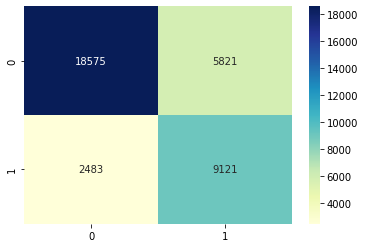

In [ ]:
# XGB 평가점수
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.35) #0.32:0.6386

In [ ]:
# 3. Light GBM
lgbm_clf = LGBMClassifier()

param_grid = {'max_depth':[7,10,13,15],    #[5~17] -> 7
              'n_estimators':[250, 280, 300]  #[100~300] -> 280
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results_lgbm = grid_search.fit(X_train, y_train)

results_lgbm.best_params_

{'max_depth': 15, 'n_estimators': 280}

In [ ]:
# LGBM best parameter를 사용하여 prediction 수행
lgbm_clf = LGBMClassifier(max_depth = results_lgbm.best_params_['max_depth'],
                                n_estimators = results_lgbm.best_params_['n_estimators'],
                                eval_metric='logloss', random_state=42)

lgbm_clf.fit(X_train, y_train)

LGBMClassifier(eval_metric='logloss', max_depth=15, n_estimators=280,
               random_state=42)


정확도: 0.7747
정밀도: 0.6155
재현율: 0.8021
AUC: 0.7819
F1: 0.6965


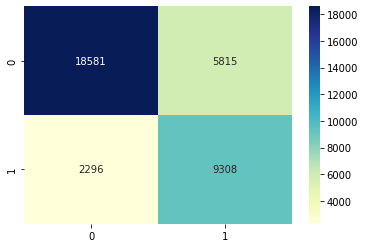

In [ ]:
# LGBM 평가점수
get_clf_eval(y_valid, lgbm_clf.predict_proba(X_valid)[:,1]>0.35)  #0.32:0.6345

In [ ]:
ada_clf = AdaBoostClassifier(n_estimators=200, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
get_clf_eval(y_valid, ada_clf.predict_proba(X_valid)[:,1]>0.5)

## 각 classifier의 feature 중요도

In [ ]:
# Feature 중요도 구하기
def feat_importance(model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
#총 data 최대한 많이해서 구하는게 의미 있음 (99%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

In [ ]:
rnd_clf = RandomForestClassifier(max_depth=16, n_estimators=250, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=250, n_jobs=-1,
                       random_state=42)

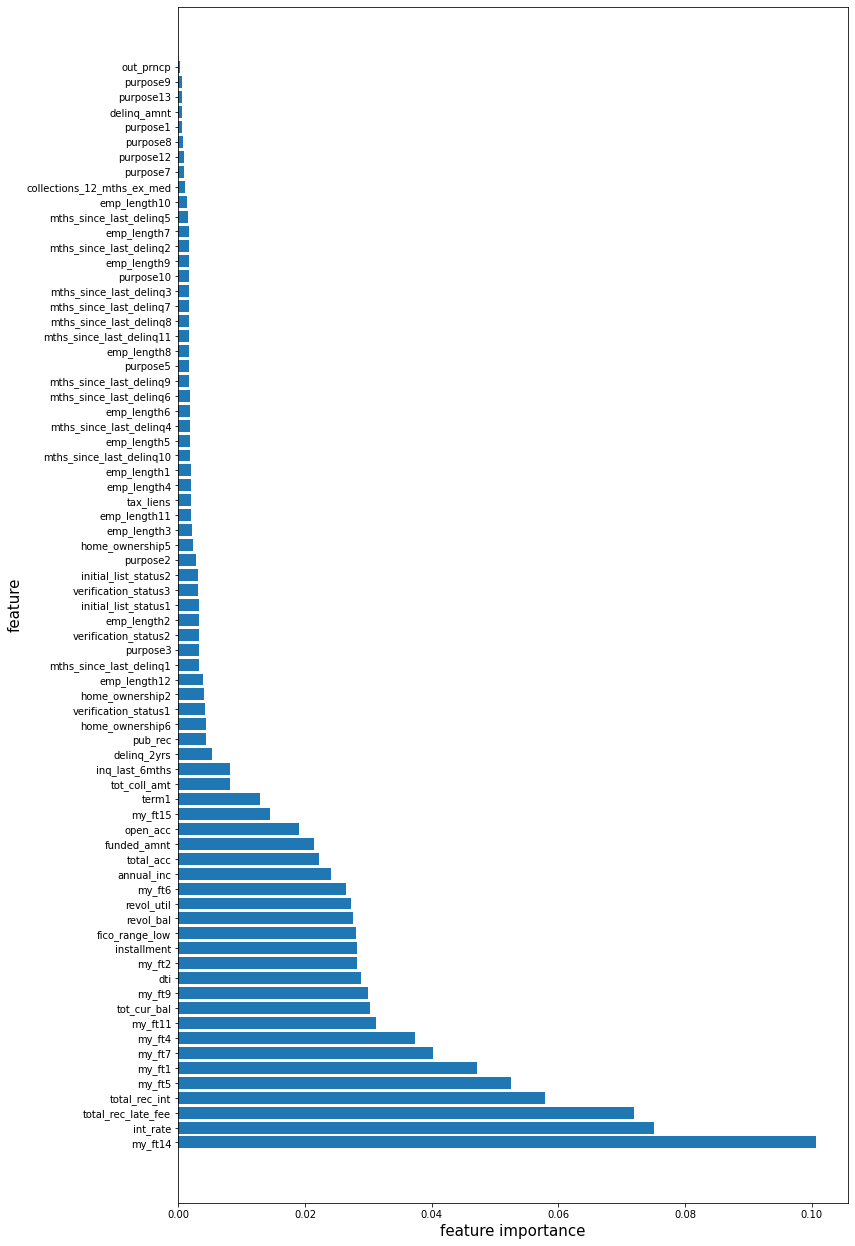

In [ ]:
rnd_fi = feat_importance(rnd_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(rnd_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, rnd_fi.imp, align='center')
plt.yticks(idx, rnd_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
get_clf_eval(y_valid, rnd_clf.predict_proba(X_valid)[:,1]>0.35)

In [ ]:
lgbm_clf = LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)

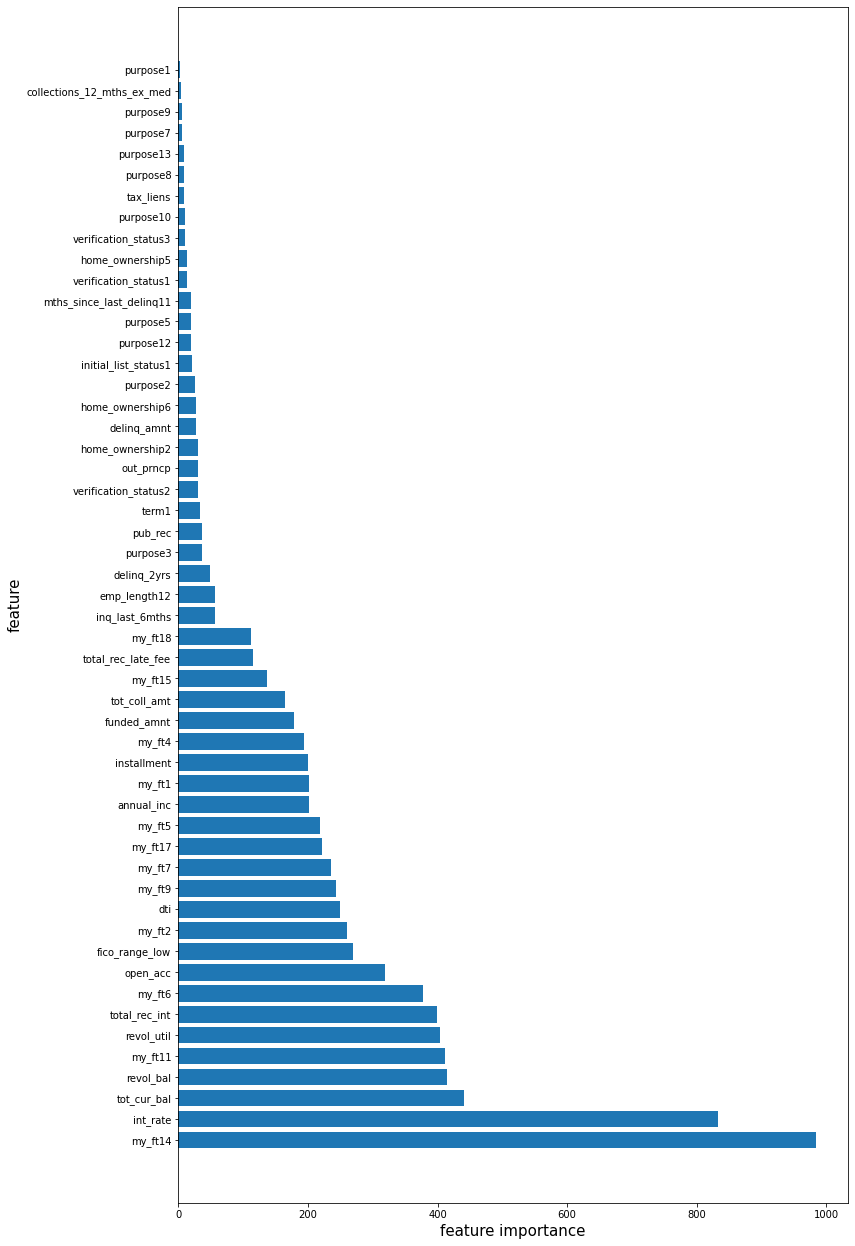

In [ ]:
lgbm_fi = feat_importance(lgbm_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(lgbm_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, lgbm_fi.imp, align='center')
plt.yticks(idx, lgbm_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()


정확도: 0.8200
정밀도: 0.7209
재현율: 0.8378
AUC: 0.8237
F1: 0.7750


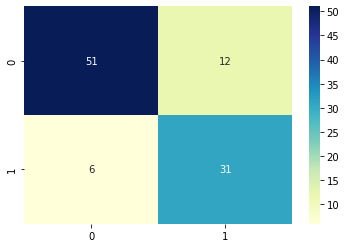

In [ ]:
get_clf_eval(y_valid, lgbm_clf.predict_proba(X_valid)[:,1]>0.35)

In [ ]:
xgb_clf = XGBClassifier(max_depth=7, n_estimators=250, 
                        objective='binary:logistic', nthread=-1,
                        random_state=42, tree_method='gpu_hist', predictor='gpu_predictor')
xgb_clf.fit(X_train, y_train, eval_metric='logloss')

XGBClassifier(max_depth=7, n_estimators=250, nthread=-1,
              predictor='gpu_predictor', random_state=42,
              tree_method='gpu_hist')

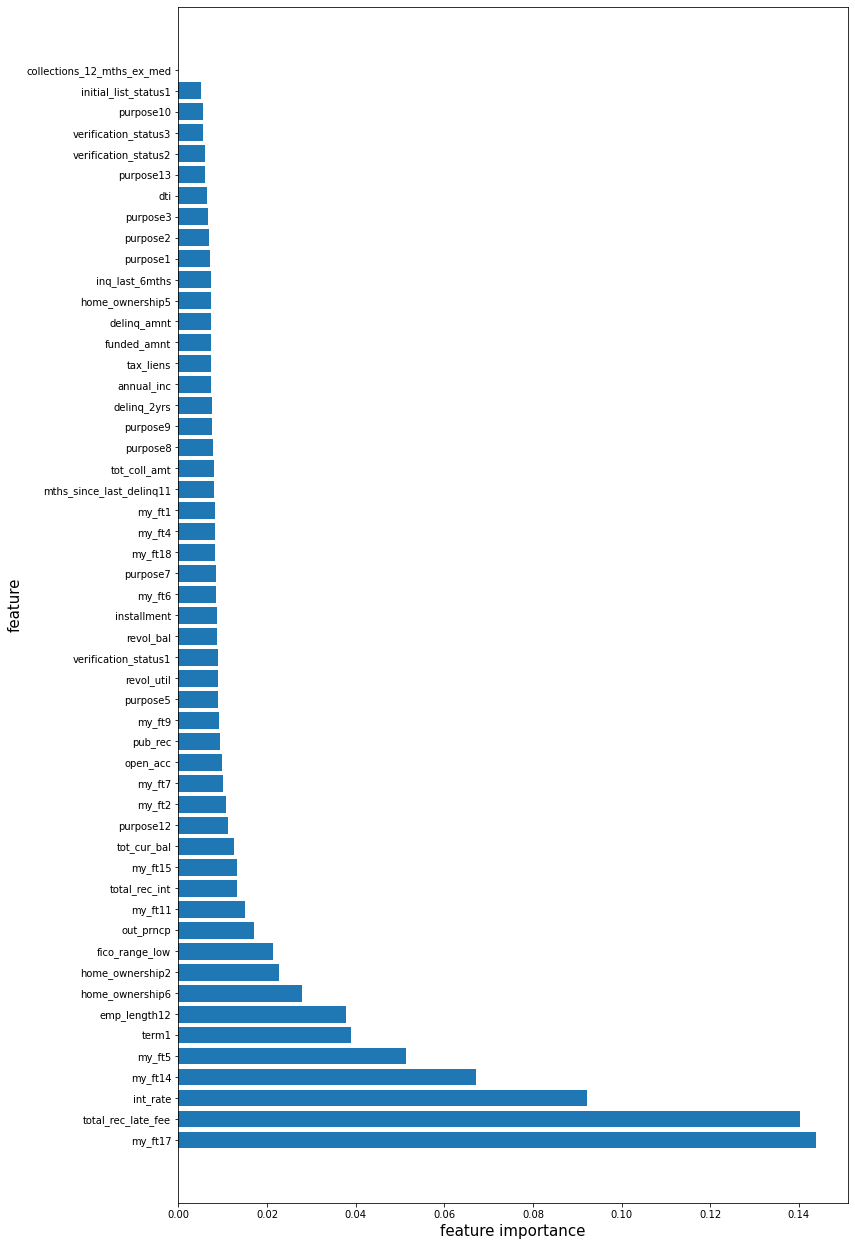

In [ ]:
xgb_fi = feat_importance(xgb_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(xgb_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, xgb_fi.imp, align='center')
plt.yticks(idx, xgb_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()


정확도: 0.8300
정밀도: 0.7500
재현율: 0.8108
AUC: 0.8260
F1: 0.7792


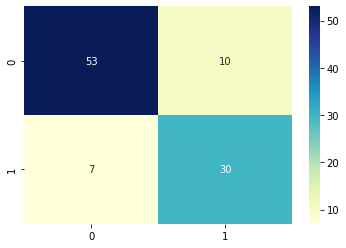

In [ ]:
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.35)

In [ ]:
min_features_to_select = 20  # Minimum number of features to consider
rfecv = RFECV(
    estimator=xgb_clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
min_features_to_select = 20  # Minimum number of features to consider
rfecv = RFECV(
    estimator=lgbm_clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

## SVM(Linear Classifier) 과 SGDClassifier(linear classifier with stochastic gradient descnet) 고찰.. 
다 형편없음. 파라미터 설정을 잘못해준건지 ㅠ  
catboost만 괜찮음

In [ ]:
# 우선 linear 타입의 classifier보다는 비선형적인 모델이 성능이 좋을 것이기 때문에 kernel='rbf'를 사용
# 학습시간 1시간 넘어서 제외

rbfsvc_clf = SVC(kernel='rbf', probability=True, random_state=42)  #default가 rbf네
rbfsvc_clf.fit(X_train, y_train)

In [ ]:
get_clf_eval(y_valid, rbfsvc_clf.predict_proba(X_valid)[:,1]>0.33)

In [ ]:
# K-neighbor
knbr_clf = KNeighborsClassifier(100)
knbr_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [ ]:
get_clf_eval(y_valid, knbr_clf.predict_proba(X_valid)[:,1]>0.33)

In [ ]:
# 일반적으로 데이터가 10만개이상 끝이없는 데이터가 있을 때는 SGD classifier 를 추천함

sgd_clf = SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42, warm_start=True)
sgd_clf.partial_fit(X_train, y_train, classes=np.unique(y_train))

SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42,
              warm_start=True)


정확도: 0.5907
정밀도: 0.3814
재현율: 0.4323
AUC: 0.5492
F1: 0.4053


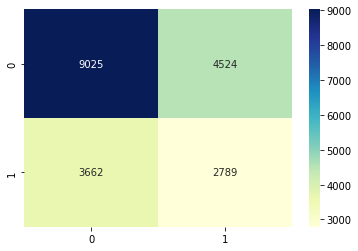

In [ ]:
get_clf_eval(y_valid, sgd_clf.predict_proba(X_valid)[:,1]>0.33)

In [ ]:
sgd_clf = SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42, warm_start=True)
sgd_clf.partial_fit(X_train, y_train, classes=np.unique(y_train))

In [ ]:
cat_clf = catboost.CatBoostClassifier(one_hot_max_size=4, iterations=200, random_seed=42, verbose=False)
cat_clf.fit(X_train, y_train)


정확도: 0.7284
정밀도: 0.5588
재현율: 0.7507
AUC: 0.7343
F1: 0.6407


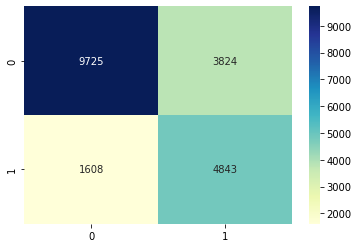

In [ ]:
get_clf_eval(y_valid, cat_clf.predict_proba(X_valid)[:,1]>0.33)

## 앙상블 fitting

In [32]:
# 최적화 한걸로 ensemble 진행
rnd_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20)

# rnd_clf2 = RandomForestClassifier()

lgbm_clf =  LGBMClassifier(max_depth=15, num_leaves = int(0.7*2**(15)), n_estimators=280, objective='binary', random_state=42)  #12 ->15

xgb_clf = XGBClassifier(max_depth=6, n_estimators=200, random_state=42,
                        objective='binary:logistic',
                        tree_method='gpu_hist', predictor='gpu_predictor')

xgb_clf2 = XGBClassifier(max_depth=12, objective='binary:logistic',
                        tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)

# cat_clf = catboost.CatBoostClassifier(one_hot_max_size=4, iterations=200, random_seed=42, verbose=False)

stacking_clf = StackingClassifier(estimators = [ ('lgbm', lgbm_clf), ('xgb', xgb_clf)
                                                ,('rnd', rnd_clf)
                                                ,('xgb2', xgb_clf2)
                                                # ,('lgbm2', lgbm_clf2)
                                                # ,('rnd2', rnd_clf2)
                                                ],       #('cat', cat_clf)
                                  # stack_method='predict_proba',
                                  final_estimator = LGBMClassifier(objective='binary',random_state=42))

stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=15, n_estimators=280,
                                               num_leaves=22937,
                                               objective='binary',
                                               random_state=42)),
                               ('xgb',
                                XGBClassifier(max_depth=6, n_estimators=200,
                                              predictor='gpu_predictor',
                                              random_state=42,
                                              tree_method='gpu_hist')),
                               ('rnd',
                                RandomForestClassifier(max_depth=16,
                                                       min_samples_leaf=8,
                                                       min_samples_split=20,
                                                       n_estimators=250)),
                        

## Test / Train 비율 조절

In [31]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

In [34]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.36, random_state=42)

## validation 진행


정확도: 0.8071
정밀도: 0.6308
재현율: 0.9681
AUC: 0.8493
F1: 0.7639

정확도: 0.8138
정밀도: 0.6403
재현율: 0.9639
AUC: 0.8532
F1: 0.7695

정확도: 0.8211
정밀도: 0.6510
재현율: 0.9595
AUC: 0.8574
F1: 0.7757

정확도: 0.8282
정밀도: 0.6618
재현율: 0.9552
AUC: 0.8615
F1: 0.7819

정확도: 0.8346
정밀도: 0.6724
재현율: 0.9494
AUC: 0.8647
F1: 0.7872

정확도: 0.8402
정밀도: 0.6827
재현율: 0.9421
AUC: 0.8669
F1: 0.7917

정확도: 0.8461
정밀도: 0.6939
재현율: 0.9351
AUC: 0.8695
F1: 0.7967

정확도: 0.8517
정밀도: 0.7060
재현율: 0.9252
AUC: 0.8710
F1: 0.8009

정확도: 0.8561
정밀도: 0.7170
재현율: 0.9149
AUC: 0.8715
F1: 0.8039

정확도: 0.8588
정밀도: 0.7247
재현율: 0.9059
AUC: 0.8711
F1: 0.8052

정확도: 0.8606
정밀도: 0.7326
재현율: 0.8939
AUC: 0.8694
F1: 0.8053


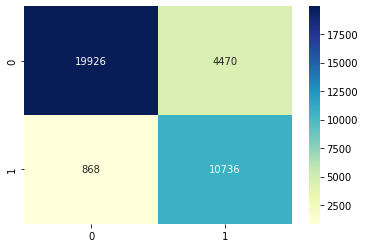

In [35]:
# 0.7727 (0.30 최대) ver03
# 0.7692 (0.36 최대) ver03 + ft16,17,18
# 0.7805 (0.36 최대) ver04 = ver03 + ft17, 18
# 0.7654 (0.34-0.36 최대) ver04 - 하위ft들 삭제 + 앙상블 증가(rnd, xgb)
# 0.7805 (0.35 최대) ver04 - 하위ft들 삭제 + 앙상블 증가(xgb)
# 0.7848 (0.37 최대) ver04 - 하위ft들 삭제                                                        #36% valid set 검사 0.7007 (0.34 최대)
# 0.7750 (0.36-0.37 최대) ver04 - 하위ft들 삭제 + ft20
# 0.7711 (0.34 최대) ver04 - 하위ft들 삭제 + 앙상블 증가(xgb_maxdepth최대화, lgbm_maxdepth최대화) #36% valid set 검사 0.7430 (0.37 최대) 현재 test 제일 잘나옴 (0.72122)
#                            하위ft들 삭제 + 앙상블 증가(xgb_maxdepth최대화, lgbm_maxdepth최대화)  + ft21 #36% valid set 검사 0.7489(0.37 최대) test낮아짐 0.719
#                            하위ft들 삭제 + 앙상블 증가(xgb_maxdepth최대화, lgbm_maxdepth최대화)  + ft20  #36% valid set 검사 0.7493(0.39 최대) test낮아짐 0.717
# 0.7654 (0.36최대) ver03 - 하위ft삭제 + 앙상블 증가(xgb, rnd, lgbm)                              # 36% 0.7340 (0.40 최대)
# 0.7750 (0.37-0.38 최대) ver04=ver03+ft17,18/ xgb, lgbm 최적화                                   # 36% 0.7395 (0.40 최대)
# 0.7781 ver04 + (xgb, lgbm 최적화)  + predict_proba # 36% 0.7384 (0.40)
# 0.7750 ver04 + (xgb, lgbm 최적화) + final estimator= lr # 36% 0.7384 (0.40)     # 36% 0.7173 (0.40 최대)
# 0.7792 (0.40 최대) ver04 + (xgb, lgbm 최적화) + final estimator=lgbm(최적화) # 36% 0.7324(0.40 최대) 과적합 되는것을 보임
# 0.7901(0.32-0.36) ver04 + (xgb, lgbm 최적화) + passthrough=True #36% 0.7151 (0.40) 뭔가 f1스코어에는 안맞는가봄.. 학습한 data로도 점수가 낮네, passthrough는 버림
# 0.7595(0.39-0.40) ver04 + (xgb, lgbm 최적화) + ft추가 삭제  #36% 0.7285 (0.37 최대) 정보삭제로 오히려 점수가 떨어지는 경향
# 0.7711 (0.37) ver04 + (xgb, lgbm 최적화) + LGBM(num_leaves = 0.6*2**(max_depth)) + ft추가 삭제 #36% 0.7706(0.40 최대) 까지 올라가는데, test점수 낮음 overfitting
# 0.7692 ver04 + (xgb, lgbm 최적화) + LGBM(num_leaves = 0.6*2**(max_depth))+ feature삭제하나도 안함 #36% 0.8483 (0.40 최대)
# 0.7857 적당히 ft만들고, 불필요한 ft삭제                                                           #36% 0.7495 (0.38 최대)
# 0.7857 적당히 ft만들고, 불필요한 ft삭제 ver2(더삭제한것)                                          #36% 0.7397 (0.38 최대)
# 0.7848 위에서 LGBM2 삭제                                                                        #36% 0.8052 (0.39 최대)
# 0.7805 마지막 final estimator에서 LGBM objective : binary 삭제하니까 점수 변화있음          #36% 0.8004 (0.39 최대)
threshold_list = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
for i in threshold_list:
    get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]> i)


heatmap_list = [0.37]
for i in heatmap_list:
    get_clf_eval2(y_valid, stacking_clf.predict_proba(X_valid)[:,1]> i)


## 제출

In [39]:
# 제출 양식 다운로드
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# test파일에도 위에서 했던 전처리 진행
df_test['my_ft1'] = df_test['int_rate']*df_test['dti']
df_test['my_ft2'] = np.log(df_test['annual_inc']*df_test['fico_range_low'])
df_test['my_ft4'] = df_test['int_rate']*df_test['funded_amnt']
df_test['my_ft5'] = df_test['int_rate']*df_test['dti']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low'])
df_test['my_ft6'] = df_test['revol_util']/(df_test['revol_bal']+0.0000001)
df_test['my_ft7'] = df_test['int_rate']*df_test['funded_amnt']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low']+2)
df_test['my_ft9'] = np.log(df_test['int_rate']*df_test['funded_amnt'])*df_test['dti']
df_test['my_ft11'] = df_test['installment']/ df_test['annual_inc']
df_test['my_ft14'] = df_test['total_rec_int']/df_test['installment']
df_test['my_ft15'] = df_test['delinq_2yrs']+2*df_test['pub_rec']+3*df_test['inq_last_6mths']
df_test['my_ft17'] = (2-(1+np.sqrt(np.log(1+df_test['term1'])+0.0001))*np.log(1+df_test['term1'])/(np.log(1+df_test['term1'])+0.0001)
                          +2*((1+np.sqrt(np.log(1+df_test['total_rec_late_fee']+0.0001)))*np.log(1+df_test['total_rec_late_fee'])/(np.log(1+df_test['total_rec_late_fee'])+0.0001))
                          +(1+1/5*(np.log(1+df_test['collections_12_mths_ex_med'])))*np.log(1+df_test['collections_12_mths_ex_med'])/(np.log(1+df_test['collections_12_mths_ex_med'])+0.0001)
                          )
df_test['my_ft18'] = (0.9*(1+np.sqrt(np.log(1+df_test['home_ownership6'])))*np.log(1+df_test['home_ownership6'])/(np.log(1+df_test['home_ownership6'])+0.0001)
                          +(1+np.log(1+df_test['verification_status3']))*np.log(1+df_test['verification_status3'])/(np.log(1+df_test['verification_status3'])+0.0001)
                          +0.5*(1+np.log(1+df_test['initial_list_status1']))*np.log(1+df_test['initial_list_status1'])/(np.log(1+df_test['initial_list_status1'])+0.0001))


# 컬럼삭제
df_test = df_test.drop(['out_prncp_inv', 'funded_amnt_inv', 'purpose4', 'fico_range_high'], axis=1)
df_test = df_test.drop(['chargeoff_within_12_mths','acc_now_delinq'], axis=1)
df_test = df_test.drop(['total_acc', 'initial_list_status2'], axis=1)
df_test = df_test.drop(['mths_since_last_delinq1',  'mths_since_last_delinq2', 'mths_since_last_delinq3',
                        'mths_since_last_delinq4', 'mths_since_last_delinq5', 'mths_since_last_delinq6',
                        'mths_since_last_delinq7', 'mths_since_last_delinq8', 'mths_since_last_delinq9',
                        'mths_since_last_delinq10'], axis=1)

# df_test=df_test.drop(['purpose1', 'purpose7', 'purpose8',
#                       'purpose9', 'purpose10', 'purpose13'
#                       ], axis=1)

threshold = 0.37
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]> threshold
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_57.csv', index=False)